This Notebook is the final solution of the Stonksmaster project!

In [ ]:
!pip install yfinance
!pip install datetime

In [641]:
# import necessary modules
from datetime import datetime as dt

import pandas as pd
import numpy as np
import requests 
import yfinance as yf
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet

In [642]:
# define constants
TOKEN = 'pk_1ff26bf4c61946f2a1df7f8efc776b9d'
TICKER_SYMBOL = 'MSFT'
API_RANGE = '1d'
LIBRARY_PERIOD = '2y'
DEFAULT_START_TIME = '09:30'
NUM_FOLDS = 5
SCORING = 'r2'
SEED = 5
URL_INTRADAY = f'https://cloud.iexapis.com/stable/stock/{TICKER_SYMBOL}/intraday-prices/batch?token={TOKEN}'
URL_HISTORICAL = f'https://cloud.iexapis.com/stable/stock/{TICKER_SYMBOL}/chart/{API_RANGE}?token={TOKEN}'

In [643]:
# generate dataframe from yfinance library
finance_df = yf.download(TICKER_SYMBOL, period=LIBRARY_PERIOD)

# remove the useless columns from the dataframe
finance_df = finance_df.loc[:, ['Open']]

# convert date field of each row to corresponding timestamp
# and create new column containing these timestamp values
timestamps = list()
finance_df.index.to_pydatetime()

for index,row in finance_df.iterrows():
  time = dt.strptime(DEFAULT_START_TIME, '%H:%M')
  timestamp = dt.timestamp(dt.combine(index.date(), time.time()))
  timestamps.append(timestamp)
finance_df.insert(0, 'Timestamp', timestamps)

# call reset_index() method to get integral indices
finance_df.reset_index(inplace=True, drop=True)
timestamps.clear()

[*********************100%***********************]  1 of 1 completed


In [644]:
# generate dataframe from historical data API
prev_day_data = requests.get(URL_HISTORICAL).json()
prev_df = pd.DataFrame(prev_day_data)

# remove useless columns from the dataframe
prev_df = prev_df.loc[:, ['date', 'minute', 'open']]

# combine date and time fields of each row to generate
# corresponding timestamp and create new column containing
# these timestamp values
historic_timestamps = list()
for index,row in prev_df.iterrows():
  date = dt.strptime(row['date'],'%Y-%m-%d')
  time = dt.strptime(row['minute'], '%H:%M')
  timestamp = dt.timestamp(dt.combine(date.date(), time.time()))
  historic_timestamps.append(timestamp)

# we require only the opening prices of the stocks along with
# the timestamps, so other columns can be dropped
prev_df = prev_df.loc[:,['open']]
prev_df.rename(columns={'open': 'Open'}, inplace=True)
prev_df.insert(0, 'Timestamp', historic_timestamps)

# append historic dataframe to finance dataframe generated earlier
finance_df = finance_df.append(prev_df, ignore_index=True)

In [645]:
# generate dataframe from intra-day data API
intra_day_data = requests.get(URL_INTRADAY).json()
curr_df = pd.DataFrame(intra_day_data)

# remove useless columns from the dataframe
curr_df = curr_df.loc[:, ['date', 'minute', 'open']]

# combine date and time fields of each row to generate
# corresponding timestamp and create new column containing
# these timestamp values
current_timestamps = list()
for index,row in curr_df.iterrows():
  date = dt.strptime(row['date'],'%Y-%m-%d')
  time = dt.strptime(row['minute'], '%H:%M')
  timestamp = dt.timestamp(dt.combine(date.date(), time.time()))
  current_timestamps.append(timestamp)

# we require only the opening prices of the stocks along with
# the timestamps, so other columns can be dropped
curr_df = curr_df.loc[:,['open']]
curr_df.rename(columns={'open': 'Open'}, inplace=True)
curr_df.insert(0, 'Timestamp', current_timestamps)

# append intraday dataframe to finance dataframe generated earlier
finance_df = finance_df.append(curr_df, ignore_index=True)

The data collection part is over and we have generated the dataframe. Next, we need to prepare the data so that it can be loaded to a ML model and the performance of different models can be ascertained.

In [646]:
# the purpose of this section is to scale the input data
# and split it into training and testing datasets

# remove infinite and nan values from the dataset
finance_df.replace([np.inf, -np.inf], np.nan, inplace=True)
finance_df.dropna(inplace=True)

# split input and output columns
X = finance_df.drop(columns=['Open'])
y = finance_df.loc[:, 'Open']

# split training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [647]:
# this section is to evaluate the performance of various models using r2 scoring
models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('Ridge', Ridge()))
models.append(('ElasticNet', ElasticNet()))
models.append(('SVR', SVR()))

results = []
for name, model in models:
  kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
  cv_result = cross_val_score(model, X_train, y_train, cv=kfold, scoring=SCORING)
  results.append(cv_result)
  print(f'{name} has mean {round(cv_result.mean(), 3)} with standard deviation {round(cv_result.std(), 3)}')


LR has mean 0.964 with standard deviation 0.005
Lasso has mean 0.964 with standard deviation 0.005
CART has mean 0.997 with standard deviation 0.001
KNN has mean 0.996 with standard deviation 0.001
Ridge has mean 0.964 with standard deviation 0.005
ElasticNet has mean 0.964 with standard deviation 0.005
SVR has mean 0.978 with standard deviation 0.004


We can see the the KNN model gives the best results. Hence, we proceed to train it with the training data set and then make predictions from it.

The r2 score of the model is 0.9963


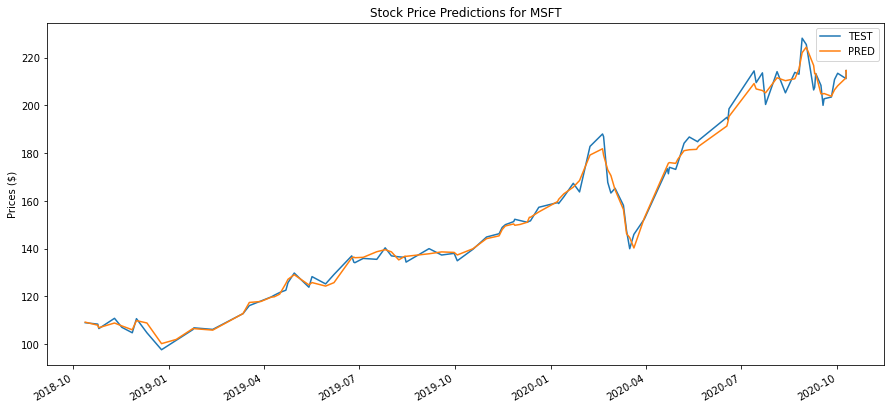

In [648]:
# we have selected the KNN model, now we can train it to make predictions
model = KNeighborsRegressor()
model.fit(X_train, y_train)

# make predictions using the model
predictions = model.predict(X_test)

# create a datetime index using the timestamps
# this  gives higher readability
datetime_index = []
for timestamp in X_test.values:
  datetime_index.append(dt.fromtimestamp(timestamp))

# print r2 score
print(f'The r2 score of the model is {round(r2_score(y_test, predictions), 4)}')

# create new dataframe containing the values to be plotted
# and make timestamps as its index
predictions_df = pd.DataFrame(datetime_index, columns=['Timestamp'])
predictions_df.insert(1, 'TEST', y_test.values)
predictions_df.insert(2, 'PRED',  predictions)
predictions_df.set_index('Timestamp', inplace=True, drop=True)

# sort according to datetime values
predictions_df.sort_index(inplace=True)

# customize and show the plot
plot_title = f'Stock Price Predictions for {TICKER_SYMBOL}'
xlabel = ''
ylabel = 'Prices ($)'
plot_size = (15,7)
predictions_df.plot(figsize=plot_size, title=plot_title, xlabel=xlabel, ylabel=ylabel)

The r2 score of the model is 0.9966


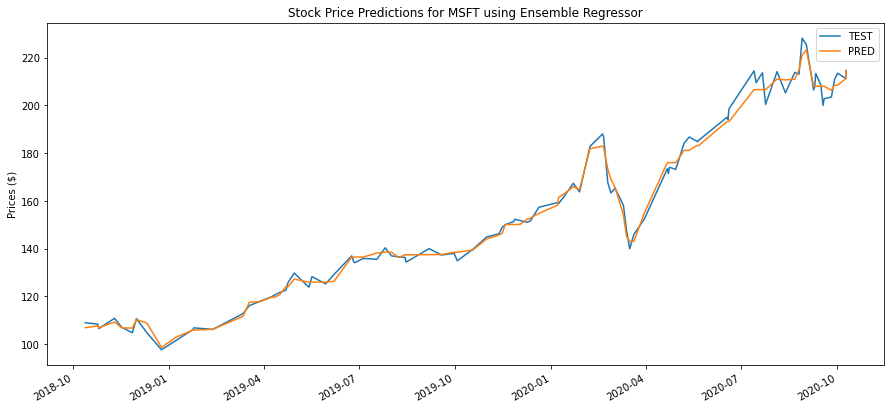

In [650]:
# we have selected the KNN model, now we can train it to make predictions
model = GradientBoostingRegressor(n_estimators=100)
model.fit(X_train, y_train)

# make predictions using the model
predictions = model.predict(X_test)

# create a datetime index using the timestamps
# this  gives higher readability
datetime_index = []
for timestamp in X_test.values:
  datetime_index.append(dt.fromtimestamp(timestamp))

# print r2 score
print(f'The r2 score of the model is {round(r2_score(y_test, predictions), 4)}')

# create new dataframe containing the values to be plotted
# and make timestamps as its index
predictions_df = pd.DataFrame(datetime_index, columns=['Timestamp'])
predictions_df.insert(1, 'TEST', y_test.values)
predictions_df.insert(2, 'PRED',  predictions)
predictions_df.set_index('Timestamp', inplace=True, drop=True)

# sort according to datetime values
predictions_df.sort_index(inplace=True)

# customize and show the plot
plot_title = f'Stock Price Predictions for {TICKER_SYMBOL} using Ensemble Regressor'
xlabel = ''
ylabel = 'Prices ($)'
plot_size = (15,7)
predictions_df.plot(figsize=plot_size, title=plot_title, xlabel=xlabel, ylabel=ylabel)